<a href="https://colab.research.google.com/github/mannmoshe/deep-learning/blob/main/medicine_imaging_project/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
import os
import shutil
import pathlib
import imageio
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from keras import layers
from keras import models

In [3]:
tf.__version__

'2.13.0'

create directories

In [4]:
!mkdir train
!mkdir validation
!mkdir test

create subdirectories for each class

In [5]:
!mkdir train/01
!mkdir train/02
!mkdir train/03

!mkdir validation/01
!mkdir validation/02
!mkdir validation/03

!mkdir test/01
!mkdir test/02
!mkdir test/03

NOTE: For running the model on your computer, please change the path below according to the location in your drive.

In [6]:
root_path = '/content/gdrive/MyDrive/M.sc Data Mining/Medicine imaging'

In [7]:
class1_path = root_path + '/data/01/'
class2_path = root_path + '/data/02/'
class3_path = root_path + '/data/03/'

In [8]:
class1_files = os.listdir(class1_path)
class2_files = os.listdir(class2_path)
class3_files = os.listdir(class3_path)

In [9]:
class1_files_sorted = sorted([x for x in class1_files])
class2_files_sorted = sorted([x for x in class2_files])
class3_files_sorted = sorted([x for x in class3_files])

In [10]:
class1_files_sorted[:5]

['01.jpeg', '010.jpeg', '011.jpeg', '012.jpeg', '013.jpeg']

In [11]:
print(len(class1_files_sorted), len(class2_files_sorted), len(class3_files_sorted))

70 70 111


split class 1 to train, validation and test

In [12]:
for f in class1_files_sorted[:35]:
  src = os.path.join(class1_path, f)
  dst = os.path.join('/content/train/01/', f)
  shutil.copyfile(src, dst)

In [13]:
for f in class1_files_sorted[35:53]:
  src = os.path.join(class1_path, f)
  dst = os.path.join('/content/validation/01/', f)
  shutil.copyfile(src, dst)

In [14]:
for f in class1_files_sorted[53:]:
  src = os.path.join(class1_path, f)
  dst = os.path.join('/content/test/01/', f)
  shutil.copyfile(src, dst)

split class 2 to train, validation and test

In [15]:
for f in class2_files_sorted[:35]:
  src = os.path.join(class2_path, f)
  dst = os.path.join('/content/train/02/', f)
  shutil.copyfile(src, dst)

In [16]:
for f in class2_files_sorted[35:53]:
  src = os.path.join(class2_path, f)
  dst = os.path.join('/content/validation/02/', f)
  shutil.copyfile(src, dst)

In [17]:
for f in class2_files_sorted[53:]:
  src = os.path.join(class2_path, f)
  dst = os.path.join('/content/test/02/', f)
  shutil.copyfile(src, dst)

split class 3 to train, validation and test

In [18]:
for f in class3_files_sorted[:35]:
  src = os.path.join(class3_path, f)
  dst = os.path.join('/content/train/03/', f)
  shutil.copyfile(src, dst)

In [19]:
for f in class3_files_sorted[35:53]:
  src = os.path.join(class3_path, f)
  dst = os.path.join('/content/validation/03/', f)
  shutil.copyfile(src, dst)

In [20]:
for f in class3_files_sorted[53:70]:
  src = os.path.join(class3_path, f)
  dst = os.path.join('/content/test/03/', f)
  shutil.copyfile(src, dst)

In [21]:
print(len(os.listdir('/content/train/01/')), len(os.listdir('/content/train/02/')), len(os.listdir('/content/train/03/')))

35 35 35


In [22]:
print(len(os.listdir('/content/validation/01/')), len(os.listdir('/content/validation/02/')), len(os.listdir('/content/validation/03/')))

18 18 18


In [23]:
print(len(os.listdir('/content/test/01/')), len(os.listdir('/content/test/02/')), len(os.listdir('/content/test/03/')))

17 17 17


VGG MODEL

In [25]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [27]:
train_dir = '/content/train/'
validation_dir = '/content/validation/'
test_dir = '/content/test/'

datagen = ImageDataGenerator(rescale=1./255)
#batch_size = 10

def extract_features(directory, sample_count, batch_size):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 3))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 35, 5)
validation_features, validation_labels = extract_features(validation_dir, 18, 9)
test_features, test_labels = extract_features(test_dir, 17, 17)

Found 105 images belonging to 3 classes.
1/1 [==============================] - 1s 1s/step
Found 54 images belonging to 3 classes.
1/1 [==============================] - 2s 2s/step
Found 51 images belonging to 3 classes.
1/1 [==============================] - 4s 4s/step


In [28]:
train_features = np.reshape(train_features, (35, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (18, 4 * 4 * 512))
test_features = np.reshape(test_features, (17, 4 * 4 * 512))

In [49]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
2/2 [==============================] - 1s 260ms/step - loss: 2.3121 - acc: 0.4571 - val_loss: 2.0692 - val_acc: 0.4444
Epoch 2/30
2/2 [==============================] - 0s 86ms/step - loss: 4.6673 - acc: 0.3429 - val_loss: 2.2252 - val_acc: 0.3889
Epoch 3/30
2/2 [==============================] - 0s 82ms/step - loss: 3.0948 - acc: 0.4286 - val_loss: 1.4264 - val_acc: 0.1667
Epoch 4/30
2/2 [==============================] - 0s 78ms/step - loss: 3.1410 - acc: 0.3714 - val_loss: 1.1349 - val_acc: 0.5000
Epoch 5/30
2/2 [==============================] - 0s 86ms/step - loss: 2.0588 - acc: 0.5429 - val_loss: 1.0745 - val_acc: 0.2778
Epoch 6/30
2/2 [==============================] - 0s 69ms/step - loss: 2.2945 - acc: 0.4000 - val_loss: 0.9509 - val_acc: 0.3889
Epoch 7/30
2/2 [==============================] - 0s 98ms/step - loss: 1.7460 - acc: 0.4000 - val_loss: 0.7309 - val_acc: 0.6667
Epoch 8/30
2/2 [==============================] - 0s 68ms/step - loss: 2.1808 - acc: 0.2000 - va

In [50]:
model.save('MODEL_3.h5')

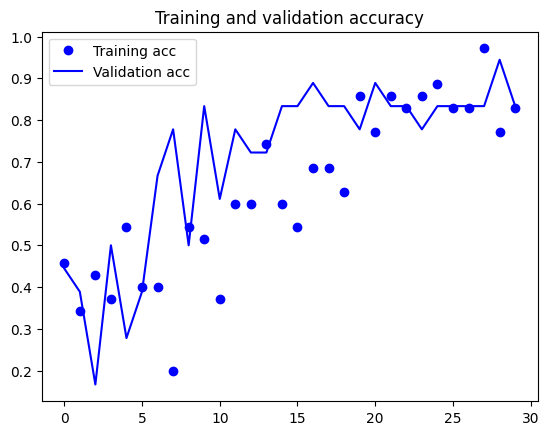

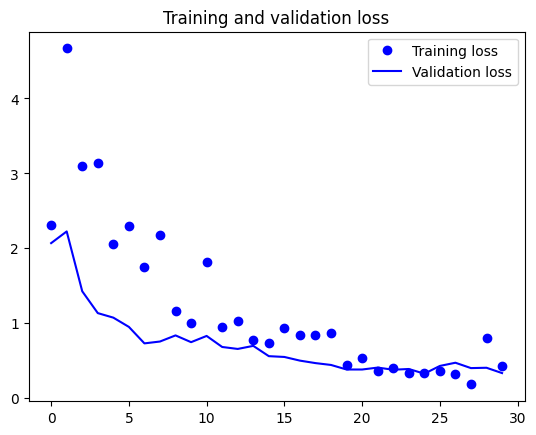

In [51]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()